# Representational Geodesic

- Introduction:
    - Linearization enables prediction
    - To test whether a model has linearized a transformation, we can synthesize a series of images along a geodesic curve in the representation space
    - Explain why we require a geodesic (curved space) 
    - maybe intro the constraints used in optimization (low energy in pixel domain)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
import plenoptic as po
import geodesics 
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
# this notebook uses torchvision, which is an optional dependency.
try:
    import torchvision
except ModuleNotFoundError:
    raise Exception("Install torchvision to use this notebook!")
import torchvision.transforms as transforms
from torchvision import models
from cycler import cycler
# we use these to change matplotlib's default way of determining plotting colors,
# for clarity
c0_rc = {'axes.prop_cycle': cycler(markerfacecolor=['w', 'C0']) + cycler(linestyle=['--', '-'])}
c1_rc = {'axes.prop_cycle': cycler(markerfacecolor=['w', 'C1']) + cycler(linestyle=['--', '-']) + cycler(color=['#ff7f0e', '#ff7f0e'])}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
po.tools.set_seed(13)

/home/billbrod/micromamba/envs/geodesics/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Two-pixel example

Representational geodesics allow us to investigate what a model considers the shortest path between two end points, by synthesizing the equally-spaced intermediate points. This may seem fairly abstract when discussing the visual system or models thereof, so let's start with a far simpler example: two-dimensional points. We'll build a couple models that transform these points into a different representation and examine the appearance of each model's geodesic.

To start, let's build a model that transforms the points $(x,y)$ into polar coordinates: $(\arctan\frac{y}{x}, \sqrt{x^2+y^2})$, and define some helper functions for visualization.

In [2]:
class PolarModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, in_tensor):
        # in_tensor is (b,c,1,data), with x on first dim of data, y on second
        # using this notation preserves the 4d shape
        # unwrap is necessary to make sure that we don't have a huge discontinuity at angle = pi/-pi
        angle = geodesics.unwrap(torch.atan2(in_tensor[...,1:], in_tensor[...,:1]), dim=0)
        dist = torch.linalg.vector_norm(in_tensor, 2, dim=-1, keepdim=True)
        return torch.concat([angle, dist], dim=1)

def plot_points(*points, fmt='-o', ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    points = torch.cat(points, dim=0).squeeze().detach()
    ax.plot(*points.T, fmt, **kwargs)
def circle(r, origin=(0,0), n=1000):
    theta = 2*np.pi/n*np.arange(0, n+1)
    return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])

model = PolarModel()
model.eval()

PolarModel()

Now let's define our initial and final points. We'll grab $(0,1)$ and a random value on the unit circle in the upper left quadrant:

In [3]:
start_angle = torch.tensor([np.pi+np.pi/4])
start = torch.cat([torch.cos(start_angle), torch.sin(start_angle)]).reshape((1,1,1,2))
angle = torch.tensor([np.pi-np.pi/4])
amp = 1
stop = torch.cat([amp*torch.cos(angle), amp*torch.sin(angle)]).reshape((1,1,1,2))

To synthesize a geodesic, we need to specify our initial and final points, our model, and how many intermediate steps we want. We'll pick a fairly high number here, so we can see what's going on.

In [4]:
# we also disable the range penalty and expand the allowed range -- while these settings are important 
# for generating images or similar stimuli, they are unnecessary in this simple example.
geo = geodesics.Geodesic(start, stop, model, 10, range_penalty_lambda=0, allowed_range=(-10,10))
# we'll also lower the stop criterion, since we're dealing with such small changes
geo.synthesize(2000, stop_criterion=1e-6, store_progress=100)


 Stop criterion for pixel_change_norm = 1.00000e-06


 54%|████████████████████████████████▊                            | 1077/2000 [00:03<00:03, 248.34it/s, loss=2.4674e-01, gradient norm=9.5598e-06, pixel change norm=6.72031e-07]/home/billbrod/Documents/geodesics/src/geodesics/geodesic.py:209: UserWarning: Pixel change norm has converged, stopping synthesis
  warnings.warn("Pixel change norm has converged, stopping synthesis")
 55%|█████████████████████████████████▋                           | 1105/2000 [00:03<00:02, 315.72it/s, loss=2.4674e-01, gradient norm=9.5598e-06, pixel change norm=6.72031e-07]


Before examining our geodesic, let's check out some diagnostics. In the plot below, we see the synthesis loss as a function of iteration, and see that we appear to have converged.

<Axes: xlabel='Synthesis iteration', ylabel='Loss'>

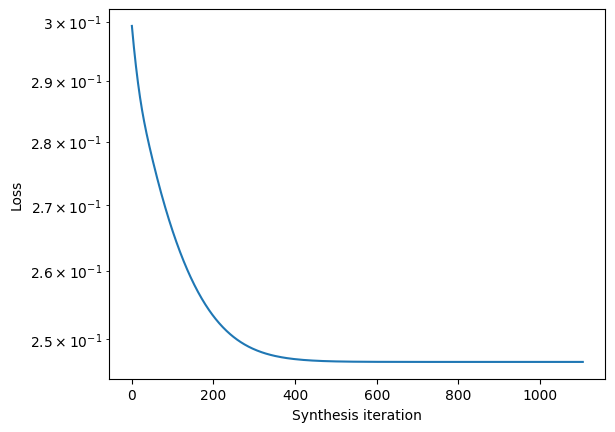

In [5]:
geodesics.plot_loss(geo)

Now let's examine our geodesic. In the following figure, we have the start and end points of our geodesic in red and the unit circle in dashed gray. The empty points show the "pixelfade", the straight line in the input space which initializes our synthesis procedure.

Before adding our geodesic, let's think through what we expect. Our model's representation consists of the distance from the origin and the angle. The pixelfade shown below changes both of these dimensions at every step by an incosistent amount. As our endpoints are both the same distance from the origin, our `PolarModel` geodesic should also keep this distance constant, only changing the angle by an equal amount on each step.

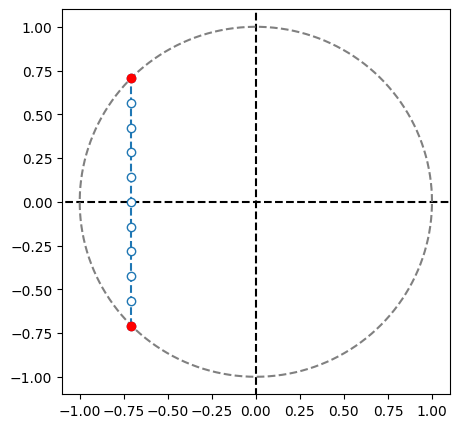

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.axhline(0, -1, 1, c='k', linestyle='--', zorder=0)
plt.axvline(0, -1, 1, c='k', linestyle='--', zorder=0)
plot_points(geo.pixelfade, fmt='--o', mfc='w', label='pixelfade')
plt.plot(*circle(1), '--', c='gray', zorder=1)
plot_points(start, stop, fmt='o', c='r', zorder=10)

And we can see that this is what the geodesic looks like! Each point is found on the unit circle, and the difference in angle between each point is consistent:

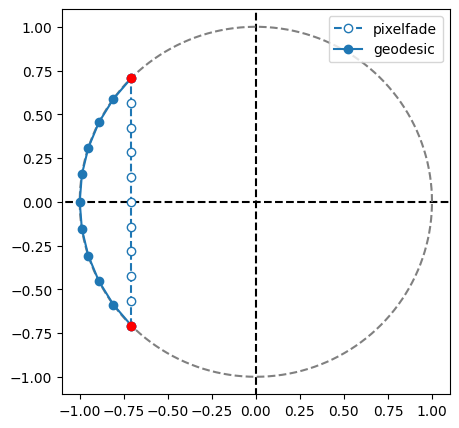

In [7]:
plot_points(geo.geodesic, c='C0', ax=ax, label='geodesic')
ax.legend(loc=1)
fig

It might be a little difficult to see that in the above plot, but we can make it clearer by looking at the model's representation of the geodesic, where we see that the distance is constant and the difference in angle between subsequent points is constant:

In [8]:
print('Distance:\n', model(geo.geodesic)[:,1].squeeze())
print('Difference in angle between point i and point i+1:\n', model(geo.geodesic)[:,0].squeeze().diff())

Distance:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<SqueezeBackward0>)
Difference in angle between point i and point i+1:
 tensor([-0.1571, -0.1571, -0.1571, -0.1571, -0.1571, -0.1571, -0.1571, -0.1571,
        -0.1571, -0.1571], grad_fn=<SubBackward0>)


We can also plot these two in the model's representation space. In the plot below, distance is shown on the y-axis and polar angle on the x. We can see that the pixelfade is very non-straight in this space: both the distance and angle are changing considerably on each step. The geodesic, on the other hand, is perfectly straight, with a constant distance and equal steps in polar angle.

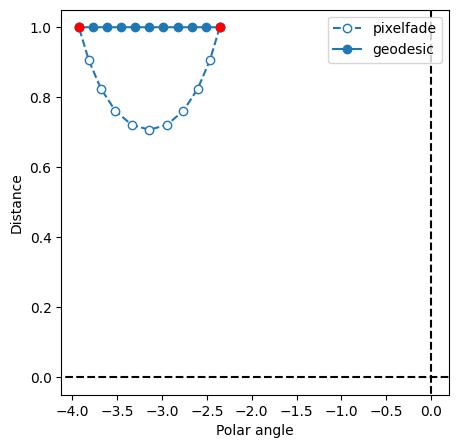

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.axhline(0, -1, 1, c='k', linestyle='--', zorder=0)
plt.axvline(0, -1, 1, c='k', linestyle='--', zorder=0)
plot_points(model(geo.pixelfade), fmt='--o', mfc='w', label='pixelfade')
# need to get the model output of all of these at once because of how unwrap works, but plot them separately so we can make the endpoints red
mdl_geo, mdl_start, mdl_stop = model(torch.cat([geo.geodesic, start, stop])).split([11, 1, 1])
plot_points(mdl_geo, c='C0', ax=ax, label='geodesic')
plot_points(mdl_start, mdl_stop, fmt='o', c='r', zorder=10)
ax.set(xlabel='Polar angle', ylabel='Distance')
ax.legend(loc=1)

In this case, we were able to easily visualize the geodesic and reason through how it should look, so checking we found a good solution was relatively straightforward. However, that generally won't be possible. The following plot should help serve as a visual diagnostic:

(cycler('markerfacecolor', ['w', 'C0']) + cycler('linestyle', ['--', '-']))


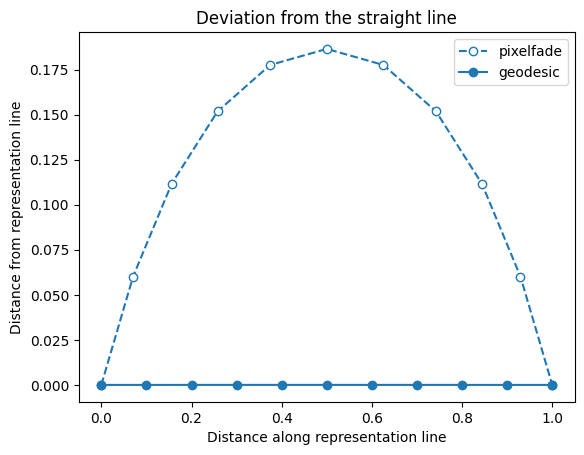

In [10]:
with mpl.rc_context(c0_rc):
    print(mpl.rcParams['axes.prop_cycle'])
    geodesics.plot_deviation_from_line(geo);

Here, we're plotting how much the pixelfade and the geodesic deviate from a straight line drawn between the two endpoints, which is the goal of our optimization. In general, the pixelfade should look highly curved in this space. If synthesis has succeeded, the geodesic should be a perfectly straight line with `y=0` and equally-spaced dots. (This isn't always possible, depending on the model, but in general, the geodesic should look *more* straight than the pixelfade.)

Let's look at another, slightly more complicated example. As before, we'll use the `PolarModel`, but now we'll take two points that vary in both dimensions. To speed things up, we'll also use a slightly higher learning rate.

In [11]:
start = torch.tensor([1.,0.]).reshape((1,1,1,2))
angle = torch.tensor([np.pi-np.pi/2*np.random.rand(1)])
amp = 5*torch.rand(1)
stop = torch.cat([amp*torch.cos(angle), amp*torch.sin(angle)]).reshape((1,1,1,2))

/tmp/ipykernel_934405/2034204226.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  angle = torch.tensor([np.pi-np.pi/2*np.random.rand(1)])


In [12]:
# we also disable the range penalty and expand the allowed range -- while these settings are important 
# for generating images or similar stimuli, they are unnecessary in this simple example.
geo = geodesics.Geodesic(start, stop, model, 10, range_penalty_lambda=0, allowed_range=(-10,10))
opt = torch.optim.Adam([geo._geodesic], lr=1e-2)
# we'll also lower the stop criterion, since we're dealing with such small changes
geo.synthesize(2000, stop_criterion=1e-6, optimizer=opt)


 Stop criterion for pixel_change_norm = 1.00000e-06


 48%|█████████████████████████████▊                                | 961/2000 [00:03<00:04, 240.24it/s, loss=1.3006e+00, gradient norm=1.1469e-06, pixel change norm=3.66471e-07]/home/billbrod/Documents/geodesics/src/geodesics/geodesic.py:209: UserWarning: Pixel change norm has converged, stopping synthesis
  warnings.warn("Pixel change norm has converged, stopping synthesis")
 48%|██████████████████████████████                                | 969/2000 [00:03<00:03, 317.47it/s, loss=1.3006e+00, gradient norm=1.1469e-06, pixel change norm=3.66471e-07]


And let's look at both diagnostics, which show we're in pretty good shape.

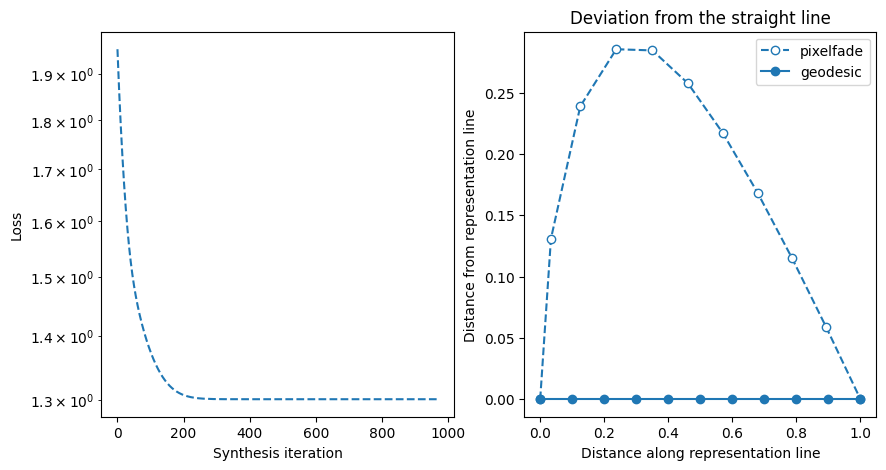

In [13]:
with mpl.rc_context(c0_rc):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    geodesics.plot_loss(geo, ax=axes[0])
    geodesics.plot_deviation_from_line(geo, ax=axes[1]);

And let's visualize our geodesic! Here, our endpoints differ in both angle and distance, so what do we expect to see? Similar to before, we'll be taking even steps in both measures, and when doing that with angle and distance, you get a spiral, as we see below:

/tmp/ipykernel_934405/3999289933.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])


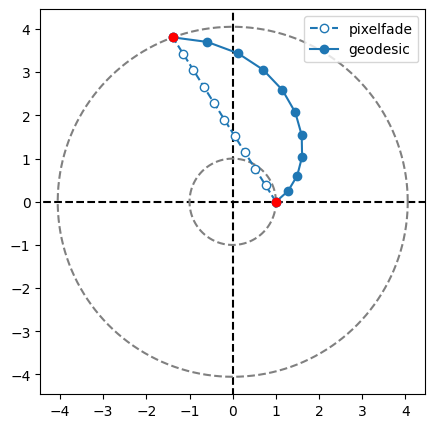

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), subplot_kw={'aspect': 'equal'})
ax.axhline(0, -1, 1, c='k', linestyle='--', zorder=0)
ax.axvline(0, -1, 1, c='k', linestyle='--', zorder=0)
ax.plot(*circle(1), '--', c='gray', zorder=1)
ax.plot(*circle(amp), '--', c='gray', zorder=1)
plot_points(geo.pixelfade, fmt='--o', mfc='w', mec='C0', ax=ax, label='pixelfade')
plot_points(start, stop, fmt='o', c='r', zorder=10, ax=ax)
plot_points(geo.geodesic, c='C0', ax=ax, label='geodesic')
ax.legend(loc=1)

And let's double check that our steps are even, both my manually inspecting the values...

In [15]:
print('Difference in distance between point i and point i+1:\n', model(geo.geodesic)[:,1].squeeze().diff())
print('Difference in angle between point i and point i+1:\n', model(geo.geodesic)[:,0].squeeze().diff())

Difference in distance between point i and point i+1:
 tensor([0.3053, 0.3053, 0.3053, 0.3053, 0.3053, 0.3053, 0.3053, 0.3053, 0.3053,
        0.3053], dtype=torch.float64, grad_fn=<SubBackward0>)
Difference in angle between point i and point i+1:
 tensor([0.1920, 0.1920, 0.1920, 0.1920, 0.1920, 0.1920, 0.1920, 0.1920, 0.1920,
        0.1920], dtype=torch.float64, grad_fn=<SubBackward0>)


And looking at the plot in representation space. We can see below that our geodesic is still a straight line, but now it's changing in both dimensions (as expected).

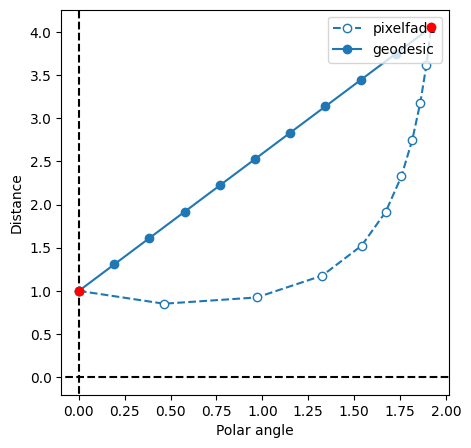

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.axhline(0, -1, 1, c='k', linestyle='--', zorder=0)
plt.axvline(0, -1, 1, c='k', linestyle='--', zorder=0)
plot_points(model(geo.pixelfade), fmt='--o', mfc='w', label='pixelfade')
# need to get the model output of all of these at once because of how unwrap works, but plot them separately so we can make the endpoints red
mdl_geo, mdl_start, mdl_stop = model(torch.cat([geo.geodesic, start, stop])).split([11, 1, 1])
plot_points(mdl_geo, c='C0', ax=ax, label='geodesic')
plot_points(mdl_start, mdl_stop, fmt='o', c='r', zorder=10)
ax.set(xlabel='Polar angle', ylabel='Distance')
ax.legend(loc=1)

Finally, let's do a different model. Here, we'll take a model that just returns the absolute value of its input, and use the same points as before.

In [17]:
class AbsModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, in_tensor):
        # in_tensor is (b,c,1,data), with x on first dim of data, y on second
        # using this notation preserves the 4d shape
        return in_tensor.abs()

model = AbsModel()
model.eval()

# we also disable the range penalty and expand the allowed range -- while these settings are important 
# for generating images or similar stimuli, they are unnecessary in this simple example.
abs_geo = geodesics.Geodesic(start, stop, model, 10, range_penalty_lambda=0, allowed_range=(-10,10))
opt = torch.optim.Adam([abs_geo._geodesic], lr=1e-2)
# we'll also lower the stop criterion, since we're dealing with such small changes
abs_geo.synthesize(500, stop_criterion=1e-6, optimizer=opt)


 Stop criterion for pixel_change_norm = 1.00000e-06


 86%|█████████████████████████████████████████████████████▉         | 428/500 [00:01<00:00, 276.72it/s, loss=1.4652e+00, gradient norm=2.4453e-07, pixel change norm=4.20168e-09]/home/billbrod/Documents/geodesics/src/geodesics/geodesic.py:209: UserWarning: Pixel change norm has converged, stopping synthesis
  warnings.warn("Pixel change norm has converged, stopping synthesis")
 89%|███████████████████████████████████████████████████████▊       | 443/500 [00:01<00:00, 327.24it/s, loss=1.4652e+00, gradient norm=2.4453e-07, pixel change norm=4.20168e-09]


And let's look at both diagnostics, which show we're in pretty good shape.

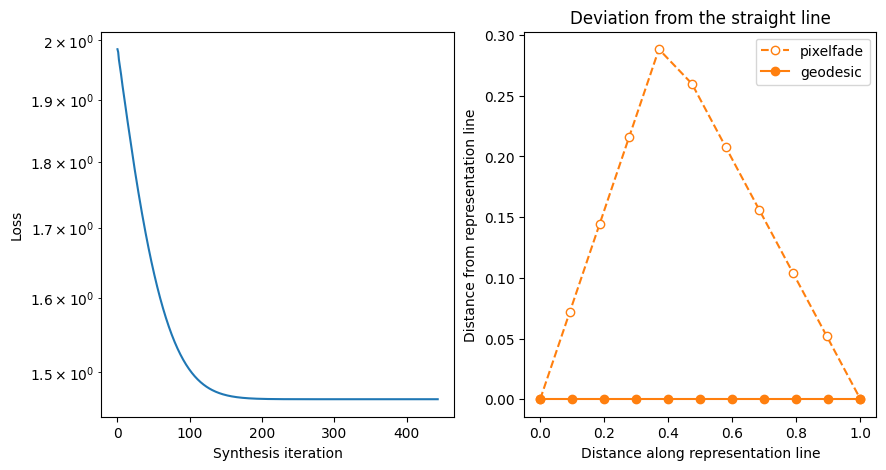

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].set_prop_cycle(c1_rc['axes.prop_cycle'])
geodesics.plot_loss(abs_geo, ax=axes[0])
geodesics.plot_deviation_from_line(abs_geo, ax=axes[1]);

What do we expect this model's geodesic to look like? It doesn't transform the points into another coordinate system, so we can expect its geodesic to look straight in pixel space. However, how does taking the absolute value affect the geodesic? As we can see below, it causes a "teleportation" after a certain number of points:

/tmp/ipykernel_934405/3999289933.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])


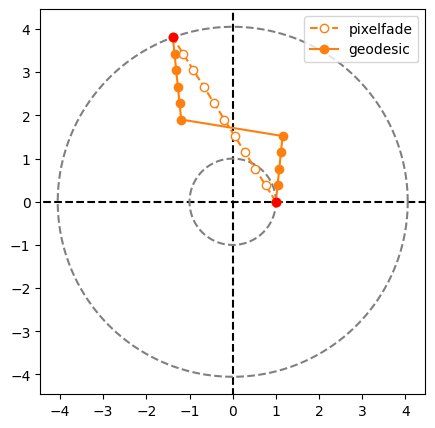

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), subplot_kw={'aspect': 'equal'})
plt.axhline(0, -1, 1, c='k', linestyle='--', zorder=0)
plt.axvline(0, -1, 1, c='k', linestyle='--', zorder=0)
plt.plot(*circle(1), '--', c='gray', zorder=1)
plt.plot(*circle(amp), '--', c='gray', zorder=1)
plot_points(geo.pixelfade, fmt='--o', mfc='w', c='C1', label='pixelfade')
plot_points(start, stop, fmt='o', c='r', zorder=10)
plot_points(abs_geo.geodesic, c='C1', ax=ax, label='geodesic')
ax.legend(loc=1)

This might seem confusing, but if we think about it, the model considers $(2, -2)$ and $(2,2)$ to be the same point, so reflecting across the axis has no effect on the distance. This can be seen more clearly if we plot the model's representation of both paths, i.e., the absolute value of all of them:

/tmp/ipykernel_934405/3999289933.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])


[(-0.1, 4.458031940460205),
 (-0.1, 4.458031940460205),
 Text(0.5, 0, '|x|'),
 Text(0, 0.5, '|y|')]

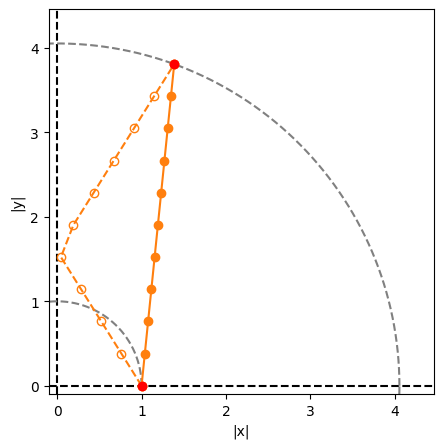

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), subplot_kw={'aspect': 'equal'})
ax.axhline(0, c='k', linestyle='--', zorder=0)
ax.axvline(0, c='k', linestyle='--', zorder=0)
plt.plot(*circle(1), '--', c='gray', zorder=1)
plt.plot(*circle(amp), '--', c='gray', zorder=1)
plot_points(model(geo.pixelfade), fmt='--o', mfc='none', c='C1')
plot_points(model(start), model(stop), fmt='o', c='r', zorder=10)
plot_points(model(abs_geo.geodesic), c='C1', ax=ax)
ax.set(xlim=(-.1, ax.get_xlim()[1]), ylim=(-.1, ax.get_ylim()[1]), xlabel='|x|', ylabel='|y|')

In the model's representational space, we can see that the geodesic is completely straight, as expected, while the pixelfade veers off unnecessarily towards the axis.

As an aside: why, you might wonder, do we only teleport over the axis once? If we look at the geodesic and the pixelfade plotted in input space, you can see that it's the result of our initialization: two points in the pixelfade start in the upper right quadrant, the rest in the upper left, and the same for the geodesic: we only flipped across the axis once because that solution was closer at hand.

## Translation

- Translation is the simplest ecologically relevant transformation
- The idea of this demo is: fourier amplitudes are invariant to translation --> the geodesics in fourier amplitude space will not correspond to translations in the pixel domain
- This is kind of a subtle point, may be difficult to communicate effectively

- Slightly more text intro: i.e. First we visualize an example in the pixel domain 

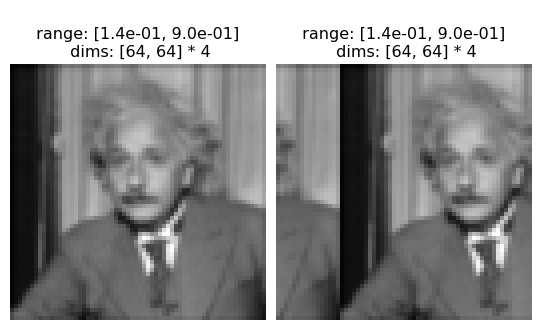

In [23]:
img = po.data.einstein()
img = po.tools.blur_downsample(img, 2)
seq = po.tools.translation_sequence(img, img.shape[-1]//4)
po.imshow(seq[[0, -1]], zoom=4);

### Spectral models
Computing a geodesic to reveal excess invariance of the global Fourier magnitude representation.

In [29]:
class Fourier(torch.nn.Module):
    def __init__(self, log_scale_amps=False):
        super().__init__()
        self.log_scale_amps = log_scale_amps
    def forward(self, x):
        fft = torch.fft.rfft2(x)
        amps = torch.abs(fft)
        if self.log_scale_amps:
            amps = torch.log(amps)
        return torch.fft.fftshift(torch.cat((amps,
                                  geodesics.unwrap(torch.angle(fft), dim=0)),
                                  # torch.angle(fft)),
                                 dim=-3), [-2])

model = Fourier()
model.eval()

Fourier()

- More text: first we instantiate a geodesic object, which requires specifying two anchor images (the algorithm finds images that lie on the geodesic connecting these two points)

In [30]:
init = po.tools.straightness.sample_brownian_bridge(seq[:1], seq[-1:], 11, 100)
init[-1] = seq[-1]

In [31]:
geo = geodesics.Geodesic(seq[:1], seq[-1:], model, 11, initial_sequence=init)# range_penalty_lambda=0)
opt = torch.optim.Adam([geo._geodesic], 1e-2, amsgrad=True)

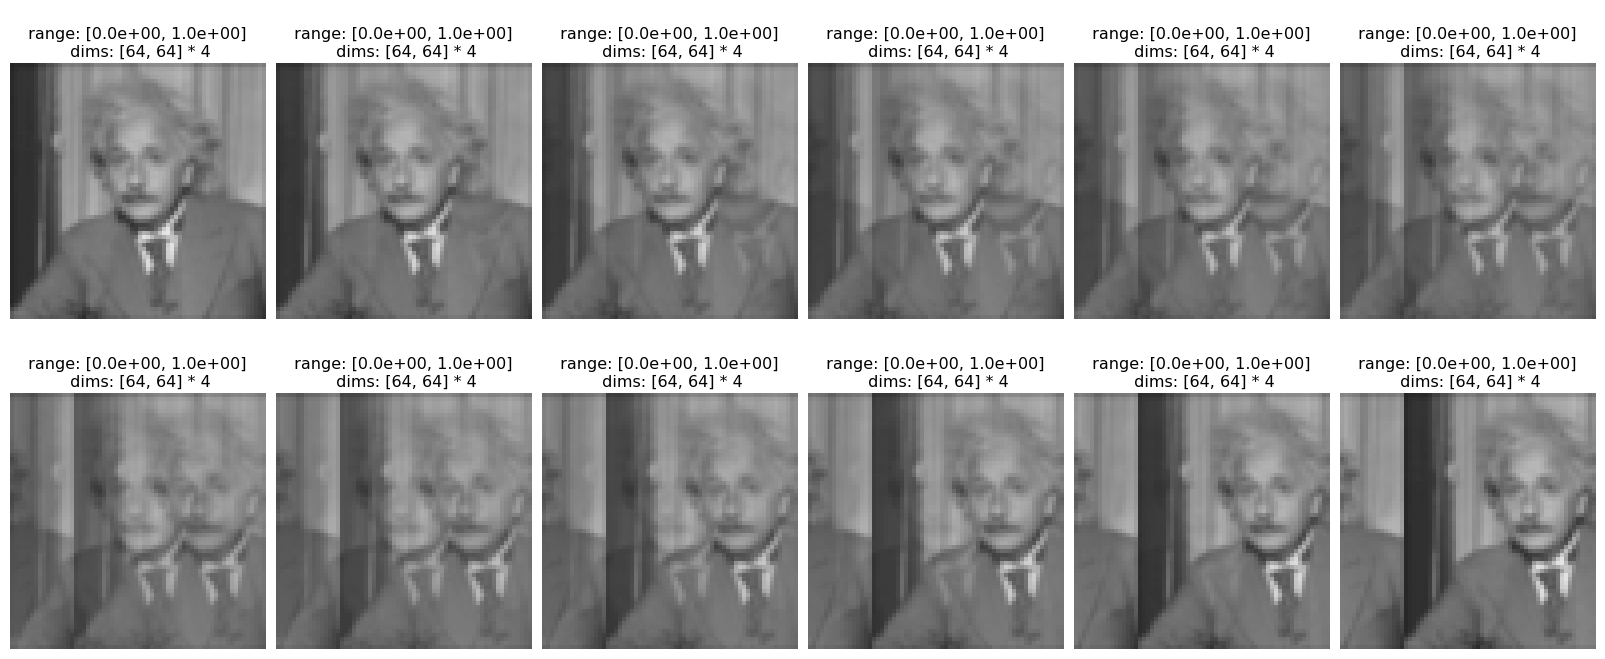

In [32]:
po.imshow(geo.pixelfade, (0, 1), zoom=4, col_wrap=6);

In [33]:
geo.synthesize(20000, stop_criterion=1e-10, store_progress=100, optimizer=opt)


 Stop criterion for pixel_change_norm = 1.00000e-10


 31%|███████████████████▏                                         | 6294/20000 [03:23<07:23, 30.89it/s, loss=3.8094e+03, gradient norm=2.2016e+03, pixel change norm=2.15591e-02]


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
geodesics.plot_loss(geo, ax=axes[0])
geodesics.plot_deviation_from_line(geo, ax=axes[1])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for st in geo.step_energy[-10:]: 
    axes[0].plot(st[:, 0])
    axes[1].plot(st[:, 1])

In [ ]:
po.imshow(geo.geodesic, (0, 1), zoom=4, col_wrap=6);

In [ ]:
fig = po.imshow(torch.log(geo.model(geo.geodesic)), 'auto0', channel_idx=0, zoom=4, title=None);
fig.suptitle('Log(Amplitude) for each step of the geodesic', y=1.1)
fig = po.imshow(torch.log(geo.model(geo.geodesic)).diff(dim=0), 'auto0', channel_idx=0, zoom=4, title=None);
fig.suptitle('Difference in Log(Amplitude) between each step in the geodesic', y=1.1)

In [ ]:
fig = po.imshow(geo.model(geo.geodesic), 'auto0', channel_idx=1, zoom=4, title=None);
fig.suptitle('Phase for each step of the geodesic', y=1.1)
fig = po.imshow(geo.model(geo.geodesic).diff(dim=0), 'auto0', channel_idx=1, zoom=4, title=None);
fig.suptitle('Difference in phase between each step in the geodesic', y=1.1)

### Physiologically inspired models

My comments on this section are just mirrored from the above. 
I like the idea of having a toy model that fails to produce a nice geodesic and a physiologically inspired model that does a slightly better job. 
From my perspective what we need to make sure of is that at each cell we are highlighting the syntax/mechanics of interacting with the geodesics module (initialization, visualization and optimization diagnostics seem to be the 3 key features to emphasize).

The above models don't throw any information away, but generally, our models do throw info away. In that case, there will be multiple possible solutions for the geodesic in representation space, so which do we pick? The solution of Henaff et al was to pick the one that was the smallest distance in pixel space as well, so let's give that a try.

In [ ]:
# Try just the amplitude model between two distinct images (einstein and curie)

In [ ]:
model = po.simul.OnOff(kernel_size=(31,31), pretrained=True)
po.imshow(model(img), zoom=4);
# po.imshow(model.conv.weight, zoom=28, vrange='auto0');

In [ ]:
n_steps = 10

moog = geodesics.Geodesic(imgA, imgB, model, n_steps, init='bridge')

print('shape trainable param', '# trainable param')
sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

Need a note to explain how we are swapping optimizer, and that points out how easy this is to do with the plenoptic module etc.

In [ ]:
try:
    from adabelief_pytorch import AdaBelief
    import adabelief_pytorch
    print(adabelief_pytorch.__version__)
    optimizer = AdaBelief([moog.x], lr=0.001, eps=1e-16, betas=(0.9,0.999),
                          weight_decouple=True, rectify=False, print_change_log=False)
except:
    optimizer = 'Adam'

In [ ]:
moog.synthesize(optimizer=optimizer)

In [ ]:
moog.plot_loss()
moog.plot_deviation_from_line();

In [ ]:
# try:
#     moog.animate_distance_from_line(vid).save("../logs/distfromline_frontend_translation.mp4")
# except:
#     print('generating the animation takes time, therefore we dont do it by default')

In [ ]:
# moog.dev_from_line[0][1]

In [ ]:
# plt.plot(po.to_numpy(torch.stack(moog., 0)[:, 1:-1]))
plt.plot(torch.stack([d[0] for d in moog.dev_from_line]));
# plt.plot(torch.stack([d[1][1:-1] for d in moog.dev_from_line]));

plt.title('evolution of distance from representation line')
plt.ylabel('distance from representation line')
plt.xlabel('iteration step')
plt.yscale('log')
plt.show()

In [ ]:
plt.plot([po.to_numpy(e) for e in moog.step_energy]);
plt.plot([e.mean() for e in moog.step_energy], 'r--', label='path energy')
plt.axhline(torch.norm(moog._analyze(moog.xA) - moog._analyze(moog.xB)) ** 2 / moog.n_steps ** 2)
plt.legend()
plt.title('evolution of representation step energy')
plt.ylabel('step energy')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

In [ ]:
try:
    moog.step_jerkiness[0]
    plt.plot([po.to_numpy(j) for j in moog.step_jerkiness]);
    plt.plot([j.mean() for j in moog.step_jerkiness], 'r--', label='path energy');
    plt.legend()
    plt.title('evolution of representation step jerkiness')
    plt.ylabel('step jerkiness')
    plt.xlabel('iteration')
    plt.yscale('log')
    plt.show()
except:
    plt.plot(moog.calculate_jerkiness())
    plt.title('final representation step jerkiness')

In [ ]:
geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()
assert geodesic.shape == pixelfade.shape
geodesic.shape

In [ ]:
print('geodesic')
pt.imshow(list(geodesic), vrange='auto1', title=None, zoom=4);
print('diff')
pt.imshow(list(geodesic - pixelfade), vrange='auto1', title=None, zoom=4);
print('pixelfade')
pt.imshow(list(pixelfade), vrange='auto1', title=None, zoom=4);

In [ ]:
# checking that the range constraint is met
plt.hist(video.flatten(), histtype='step', density=True, label='video')
plt.hist(pixelfade.flatten(), histtype='step', density=True, label='pixelfade')
plt.hist(geodesic.flatten(), histtype='step', density=True, label='geodesic');
plt.yscale('log')
plt.title('signal value histogram')
plt.legend(loc=1)
plt.show()

## vgg16 translation / rotation / scaling  

This section is not ready. We are unsure why we could not reproduce the results of the paper, but regardless I don't think this example is necessary for the purpose of a tutorial

In [ ]:
# We have some optional example images that we'll download for this. In order to do so,
# we use an optional dependency, pooch. If the following raises an ImportError or ModuleNotFoundError for you,
# then install pooch in your plenoptic environment and restart your kernel.
sample_image_dir = po.data.fetch_data('sample_images.tar.gz')
imgA = po.load_images(sample_image_dir / 'frontwindow_affine.jpeg', as_gray=False)
imgB = po.load_images(sample_image_dir / 'frontwindow.jpeg', as_gray=False)
u = 300
l = 90
imgA = imgA[..., u:u+224, l:l+224]
imgB = imgB[..., u:u+224, l:l+224]
po.imshow([imgA, imgB], as_rgb=True);
diff = imgA - imgB
po.imshow(diff);
pt.image_compare(po.to_numpy(imgA, True), po.to_numpy(imgB, True));

In [ ]:
from torchvision import models
# Create a class that takes the nth layer output of a given model
class NthLayer(torch.nn.Module):
    """Wrap any model to get the response of an intermediate layer
    
    Works for Resnet18 or VGG16.
    
    """
    def __init__(self, model, layer=None):
        """
        Parameters
        ----------
        model: PyTorch model
        layer: int
            Which model response layer to output
        """
        super().__init__()

        # TODO
        # is centrering appropriate??? 
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        try:
            # then this is VGG16
            features = list(model.features)
        except AttributeError:
            # then it's resnet18
            features = ([model.conv1, model.bn1, model.relu, model.maxpool] + [l for l in model.layer1] + 
                        [l for l in model.layer2] + [l for l in model.layer3] + [l for l in model.layer4] + 
                        [model.avgpool, model.fc])
        self.features = nn.ModuleList(features).eval()

        if layer is None:
            layer = len(self.features)
        self.layer = layer

    def forward(self, x):
        
        x = self.normalize(x)
        for ii, mdl in enumerate(self.features):
            x = mdl(x)
            if ii == self.layer:
                return x

# different potential models of human visual perception of distortions
# resnet18 = NthLayer(models.resnet18(pretrained=True), layer=3)

# choosing what layer representation to study
# for l in range(len(models.vgg16().features)):
#     print(f'({l}) ', models.vgg16().features[l])   
#     y = NthLayer(models.vgg16(pretrained=True), layer=l)(imgA) 
#     print("dim", torch.numel(y), "shape ", y.shape,)

vgg_pool1 = NthLayer(models.vgg16(pretrained=True), layer=4)
vgg_pool2 = NthLayer(models.vgg16(pretrained=True), layer=9)
vgg_pool3 = NthLayer(models.vgg16(pretrained=True), layer=17)

In [ ]:
# out of curiosity, if we are going to use a classifier
# I wonder how stable the predicted label is along the geodesic
predA = po.to_numpy(models.vgg16(pretrained=True)(imgA))[0]
predB = po.to_numpy(models.vgg16(pretrained=True)(imgB))[0]

plt.plot(predA);
plt.plot(predB);

The following block runs `curl` (which should be automatically installed on your system) to download a `txt` file containing the ImageNet class labels. If it doesn't run for some reason, you can download it yourself from [here](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt) and place it at `./imagenet1000_clsidx_to_labels.txt`.

In [22]:
!curl https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt -o ./imagenet1000_clsidx_to_labels.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30564  100 30564    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k


In [ ]:
with open("./imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

for idx in np.argsort(predA)[-5:]:
    print(idx2label[idx])
for idx in np.argsort(predB)[-5:]:
    print(idx2label[idx])

In [ ]:
moog = geodesics.Geodesic(imgA, imgB, vgg_pool3)
torch.numel(imgA), torch.numel(moog.model(imgA)), moog.model(imgA).shape, [p.shape for p in moog.parameters() if p.requires_grad]

In [ ]:
# this should be run for longer on a GPU
moog.synthesize(max_iter=25, learning_rate=.001)

In [ ]:
moog.plot_loss()
moog.plot_deviation_from_line();

In [ ]:
try:
    moog.step_jerkiness[0]
    plt.plot([po.to_numpy(j) for j in moog.step_jerkiness]);
    plt.plot([j.mean() for j in moog.step_jerkiness], 'r--', label='path energy');
    plt.legend()
    plt.title('evolution of representation step jerkiness')
    plt.ylabel('step jerkiness')
    plt.xlabel('iteration')
    plt.yscale('log')
    plt.show()
except:
    plt.plot(moog.calculate_jerkiness())
    plt.title('final representation step jerkiness')

In [ ]:
po.imshow(moog.geodesic, as_rgb=True, zoom=2, title=None, vrange='auto0');
po.imshow(moog.pixelfade, as_rgb=True, zoom=2, title=None, vrange='auto0');
# per channel difference
po.imshow([(moog.geodesic - moog.pixelfade)[1:-1, 0:1]], zoom=2, title=None, vrange='auto1');
po.imshow([(moog.geodesic - moog.pixelfade)[1:-1, 1:2]], zoom=2, title=None, vrange='auto1');
po.imshow([(moog.geodesic - moog.pixelfade)[1:-1, 2:]], zoom=2, title=None, vrange='auto1');
# exaggerated color difference
po.imshow([po.tools.rescale((moog.geodesic - moog.pixelfade)[1:-1])], as_rgb=True, zoom=2, title=None);

In [ ]:
# TODO pick anchor frames that are further apart, here too small motion?